In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import *

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
meta = MetaData()

In [7]:
station = Table('station', meta, autoload_with=engine, extend_existing=True)
measurement = Table('measurement', meta, Column('date', Date), autoload_with=engine, extend_existing=True)

In [8]:
for c in measurement.columns:
    print(c, c.type)

for c in station.columns:
    print(c, c.type)

measurement.id INTEGER
measurement.station TEXT
measurement.date DATE
measurement.prcp FLOAT
measurement.tobs FLOAT
station.id INTEGER
station.station TEXT
station.name TEXT
station.latitude FLOAT
station.longitude FLOAT
station.elevation FLOAT


In [9]:
session = Session(engine)

# Exploratory Climate Analysis

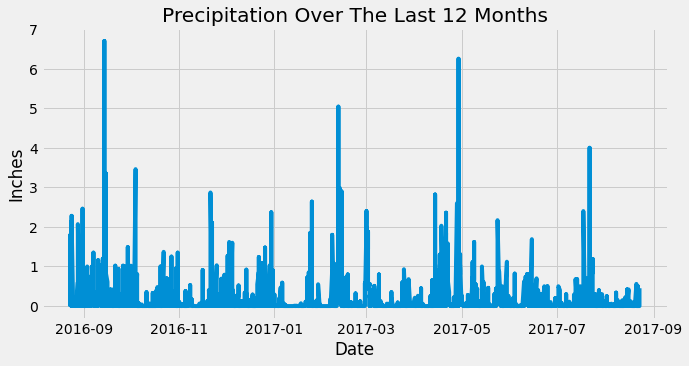

In [18]:
last_date = session.query(func.max(measurement.c.date)).first()[0]
year_ago = last_date - dt.timedelta(days=365)

prev_year_prcp = session.query(measurement.c.date, measurement.c.prcp).\
    filter(measurement.c.date >= year_ago).all()

df_prev_year_prcp = pd.DataFrame(prev_year_prcp, columns=['date','precipitation'])
df_prev_year_prcp.precipitation = df_prev_year_prcp.precipitation.fillna(0)

df_prev_year_prcp.set_index('date', inplace=True)

ax = df_prev_year_prcp.plot(title='Precipitation Over The Last 12 Months', figsize=(10,5))
ax.set_ylabel('Inches')
ax.set_xlabel('Date')
ax.get_legend().remove()

plt.show()

In [11]:
df_prev_year_prcp.describe()

,precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [12]:
total_stations = session.query(func.count(station.c.id)).first()[0]
print(f'There are {total_stations} stations in this dataset')

There are 9 stations in this dataset


In [13]:
stations = session.query(station.c.name, station.c.station, func.count(measurement.c.station).label('measurements')).\
    filter(station.c.station == measurement.c.station).\
    group_by(station.c.name, station.c.station)

df_stations = pd.DataFrame(stations.all(), columns=['station', 'station_id', 'measurements'])
df_stations.set_index('station', inplace=True)
df_stations.sort_values(by='measurements', ascending=False, inplace=True)
df_stations.head(total_stations)


,station_id,measurements
station,,
"WAIHEE 837.5, HI US",USC00519281,2772
"WAIKIKI 717.2, HI US",USC00519397,2724
"KANEOHE 838.1, HI US",USC00513117,2709
"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
"PEARL CITY, HI US",USC00517948,1372
"UPPER WAHIAWA 874.3, HI US",USC00518838,511


In [14]:
most_active_station = df_stations.max().station_id

temp_agg = session.query(func.min(measurement.c.tobs), func.max(measurement.c.tobs), func.avg(measurement.c.tobs)).\
    filter(measurement.c.station == most_active_station).all()[0]

print(f'Below are some temperature (F) statitstics for station {most_active_station} \n\
Lowest Recorded Temperature: {temp_agg[0]} \n\
Highest Recorded Temperature: {temp_agg[1]} \n\
Average Temperature: {round(temp_agg[2], 1)}')

Below are some temperature (F) statitstics for station USC00519523 
Lowest Recorded Temperature: 56.0 
Highest Recorded Temperature: 85.0 
Average Temperature: 74.5


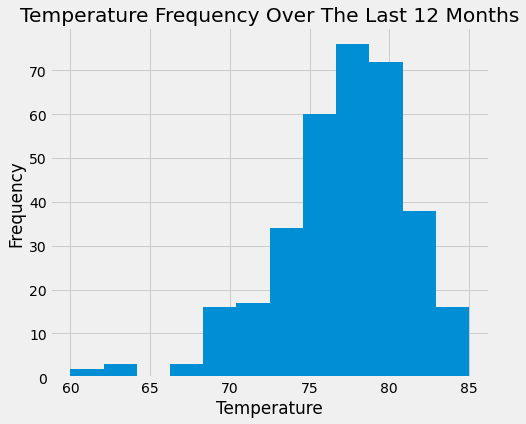

In [15]:
station_temps = session.query(measurement.c.tobs).\
    filter(measurement.c.station == most_active_station).filter(measurement.c.date >= year_ago).\
    all()

df_temps = pd.DataFrame(station_temps, columns=['temp'])

ax = df_temps.plot(kind='hist', bins=12, title='Temperature Frequency Over The Last 12 Months', figsize=(7,6))
ax.set_ylabel('Frequency')
ax.set_xlabel('Temperature')
ax.get_legend().remove()

plt.show()